In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Perceptrons

In [3]:
iris = load_iris()
x = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

per_clf = Perceptron(random_state=42)
per_clf.fit(x, y)

y_pred = per_clf.predict([[2, 0.5]])
y_pred

array([1])

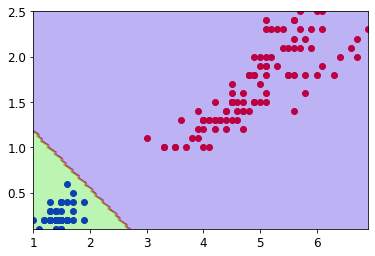

In [4]:
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], c='r')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], c='b')

xx = np.linspace(np.min(x[:, 0]), np.max(np.max(x[:, 0])), 100)
yy = np.linspace(np.min(x[:, 1]), np.max(np.max(x[:, 1])), 100)

xs, ys = np.meshgrid(xx, yy)
x_new = np.c_[xs.ravel(), ys.ravel()]
y_new = per_clf.predict(x_new).reshape(xs.shape)

plt.contourf(xs, ys, y_new, cmap=plt.cm.brg, alpha=0.3)
plt.show()

# Implementing MLPs with Keras

In [5]:
import tensorflow as tf
from tensorflow import keras

'tensorflow', tf.__version__, 'keras', keras.__version__

('tensorflow', '2.1.0', 'keras', '2.2.4-tf')

### Image Classifier  

In [6]:
fashion_mnist = keras.datasets.fashion_mnist

(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
#try shufling dataset to inprove learning rate
idx = np.arange(len(X_train_full))
X_train_full = X_train_full[idx]
y_train_full = y_train_full[idx]

In [8]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [9]:
X_train, y_train = X_train_full[:50000] / 255., y_train_full[:50000]
X_valid, y_valid = X_train_full[50000:] / 255., y_train_full[50000:]
X_test = X_test / 255.

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
def plot_mnist(data, labels, n_cols=5):
    n_rows = (len(data) - 1) // n_cols + 1
    plt.figure(figsize=(1.5*n_cols, 1.5*n_rows))
    for index, (face, label) in enumerate(zip(data, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(class_names[label])
    plt.show()

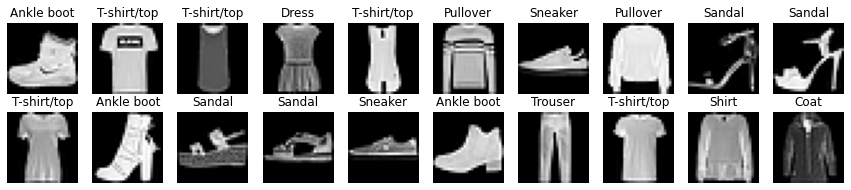

In [12]:
plot_mnist(X_train_full[:20], y_train_full[:20], 10)

**review Sequential API**

Нейросеть с 2я скрытыми слоями

In [13]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

layers can be added this way

In [14]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [15]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.layers

In [18]:
model.layers[1].name

'dense'

In [19]:
model.get_layer('dense_2').name

'dense_2'

In [20]:
weights, biases = model.get_layer('dense_2').get_weights()

In [21]:
print(weights.shape)
print(biases.shape)

(100, 10)
(10,)


**compile and learn**

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid), 
                    workers=4, use_multiprocessing=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 9s 184us/sample - loss: 0.7375 - accuracy: 0.7602 - val_loss: 0.5185 - val_accuracy: 0.8245
Epoch 2/30
50000/50000 [==============================] - 9s 176us/sample - loss: 0.4899 - accuracy: 0.8312 - val_loss: 0.5004 - val_accuracy: 0.8285
Epoch 3/30
50000/50000 [==============================] - 9s 172us/sample - loss: 0.4462 - accuracy: 0.8438 - val_loss: 0.4424 - val_accuracy: 0.8448
Epoch 4/30
50000/50000 [==============================] - 9s 172us/sample - loss: 0.4178 - accuracy: 0.8547 - val_loss: 0.4358 - val_accuracy: 0.8469
Epoch 5/30
50000/50000 [==============================] - 8s 170us/sample - loss: 0.3997 - accuracy: 0.8603 - val_loss: 0.4411 - val_accuracy: 0.8446
Epoch 6/30
50000/50000 [==============================] - 9s 173us/sample - loss: 0.3813 - accuracy: 0.8659 - val_loss: 0.3888 - val_accuracy: 0.8635
Epoch 7/30
50000/50000 [==========================

In [24]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1563,
 'samples': 50000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

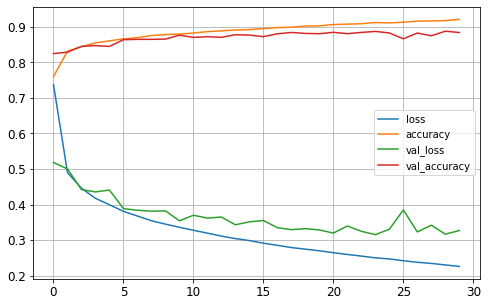

In [26]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)

In [27]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 101us/sample - loss: 0.3507 - accuracy: 0.8739


[0.35066279246807097, 0.8739]

**Using the Model to Make Predictions** 

In [75]:
k = 10
x_new = X_test[:k]
y_pred = model.predict(x_new).round(2)
y_pred

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.19, 0.  , 0.01, 0.  , 0.  , 0.  , 0.79, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.95, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

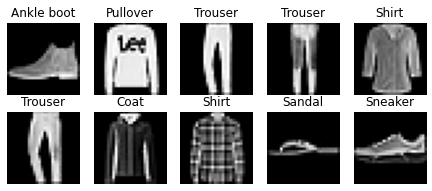

object 0 - 1.0% - Sandal
object 0 - 1.0% - Sneaker
object 0 - 98.0% - Ankle boot
object 1 - 98.0% - Pullover
object 1 - 2.0% - Coat
object 2 - 100.0% - Trouser
object 3 - 100.0% - Trouser
object 4 - 19.0% - T-shirt/top
object 4 - 1.0% - Pullover
object 4 - 79.0% - Shirt
object 5 - 100.0% - Trouser
object 6 - 99.0% - Coat
object 6 - 1.0% - Shirt
object 7 - 5.0% - Coat
object 7 - 95.0% - Shirt
object 8 - 100.0% - Sandal
object 9 - 100.0% - Sneaker


In [76]:
plot_mnist(X_test[:k], y_test[:k])

for i in range(len(x_new)):
    for j in range(10):
        if (y_pred[i][j] != 0):
            print("object {} - {:.4}% - {}".format(i, y_pred[i][j] * 100, class_names[j]))

### Regression example